### Changes from Version 0


1. Confine entire locations if the test result is positive
2. Removed (irrelevant) "is_dead" array
3. Removed all trace of "dead" states

**Note:** Gillespie unchanged since v0

**TODO:**
1. Change Gillespie
2. Implement reduced transmission for quarantined people

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
from numpy.random import randint,uniform,choice

In [123]:
def Tau_Leap(rate, Cpars, Tpars, n0, old_pop, old_n_per_loc, T,home_loc_state):
    
    random_test_rate =Tpars[0]
    test_sensitivity =Tpars[1]
    test_specificity =Tpars[2]
    finish_test_rate =Tpars[3]
    
    pop = np.copy(old_pop)
    n_per_location = np.copy(old_n_per_loc)
    
    is_confined = np.zeros(n_pop,bool)               # Boolean array, is confined? (Initial values, all "no".)
    being_tested= np.zeros(n_pop,bool)               # Boolean array, is being tested?
    loc_confined= np.zeros(n_loc,bool)               # Boolean array, is the location confined? <---NEW
    
    test_result = np.zeros(n_pop,int)                # Array to hold results of test (+1 positive, -1 negative)
    
    loc_confined_time = np.zeros(n_loc,float)        # Time when a location was confined
    for i in range(0,n_loc):
        loc_confined_time[i] = -1000                 # Set the confined time of all locations to be "\infty"
    total_loc_confined_time = 10
    
    locked = []
    tests_conducted = 0
    results_declared= 0
    locations_moved = 0
    
    dt = 0.1
    
    n = np.copy(n0)
    N = np.sum(n)

    transitions = np.zeros((n_states,n_states),int)
    
    output = np.append(0,n0)
    
    t=0.0
    
    v = np.array([[-1, 0, 0, 0, 0, 0],       # Array to denote change per state per event
                  [ 1,-1,-1, 0, 0, 0],       # The row indexes the state variables, and the
                  [ 0, 1, 0,-1,-1, 0],       # column indexes the events. The number represents
                  [ 0, 0, 1, 1, 0, 1],
                  [ 0, 0, 0, 0, 1,-1]],int)  # the change in that particular state, given an event.

    r = np.zeros(n_events)             # Empty array to store rates per event
    K = np.zeros(n_events,int)         # Empty array to store number of events that occur in dt (Poisson distributed)
    
    
    
    while(t < T):
        
        for i in range(0, n_loc):                 # Loop over locations
            
            indices = np.where(pop[:,3]==i)[0]    # Index in pop of individuals in this location
            
            N = len(indices)
            
            if(N==0):
                continue                         # If there's no one in this location, try the next one
            
            V = 1#10/(np.exp(-0.2*N) + 1)
            
#             if(N<=10):
#                 V = N
#             else:
#                 V = 10

#             This part can be done more efficiently using a matrix, but that's for later

            r[0] = rate[0][1] * n_per_location[i][0] * 1/V * (Cpars[1]*n_per_location[i][1] + Cpars[2]*n_per_location[i][2] + Cpars[4]*n_per_location[i][4])/1
            r[1] = rate[1][2] * n_per_location[i][1]
            r[2] = rate[1][3] * n_per_location[i][1]
            r[3] = rate[2][3] * n_per_location[i][2]
            r[4] = rate[2][4] * n_per_location[i][2]
            r[5] = rate[4][3] * n_per_location[i][4]
            
            ##### Adaptive Step Sizes ##########
            
#             eps= 0.4
#             mu = np.dot(v,r)
#             sigsq= np.dot(v**2,r)
#             g  = np.array([2,2,1,1])
            
#             b = np.zeros(n_states)
            
#             for j in range(0,n_states):
#                 b[j] = max(eps * n_per_location[i][j] / g[j], 1)
            
#             b1 = b/np.abs(mu)
#             b2 = b**2/sigsq
            
#             dt = min(b1.any(),b2.any())
            
            ######################################
            
             
            for j in range(0,n_events):
                K[j] = np.random.poisson(r[j]*dt)
            

            n_per_location[i] += np.dot(v,K)            # Change number per location by Sum_j v_ij K_j 
                         
            transitions[0][1] = K[0]
            transitions[1][2] = K[1]
            transitions[1][3] = K[2]
            transitions[2][3] = K[3]
            transitions[2][4] = K[4]
            transitions[4][3] = K[5]
            
            
            if(np.all(transitions==0)):             # Skip this loop 
                continue
            
            done = np.zeros(len(indices),bool)      # Array to make sure same individual isn't shifted more than once


            for j in range(0,n_states):
                for k in range(0,n_states):
                    l=0
                    for m in range(0,len(indices)): # Go over everyone in this location
                        if(l==transitions[j][k]):
                            break

                        if(pop[indices[m]][0] == j and not done[m]):  # If they are j
                            pop[indices[m]][0] = k    # change them to k
                            n[j] -= 1                 # Decrement number of j
                            n[k] += 1                 # Increment number of k
                            
                            if(k==4):                 # If they are hospitalised
                                h = randint(n_hospitals)
                                n_per_location[pop[indices[m]][3]][j] -= 1 # Decrement the number of j in current location
                                
                                pop[indices[m]][3] = h # Send them to a random hospital
                                n_per_location[pop[indices[m]][3]][k] += 1 # Increment the number of k in current (hospital) location
                                
                            done[m] = True            # Don't repeat this index
                            l += 1

        for i in range(0,n_pop):
            
            # Conduct a certain number of random tests per person per dt with probability p
                            
            p = np.random.uniform(0.0,1.0)
            
            if(being_tested[i] == False and p < random_test_rate * dt):  # If the person isn't currently being tested, 
                                                                         # a test is performed with some probability random_test_rate*dt
                # Perform a test
                being_tested[i] = True
                
                tests_conducted += 1
                
                if ((pop[i][0]==1 or pop[i][0]==2) 
                    and uniform(0.0,1.0)<test_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3 or pop[i][0]==4) 
                                                                and uniform(0.0,1.0)>test_specificity): # If the person is infected and the test works 
                
                    test_result[i] = 1
                
                else:
                    test_result[i] = -1
                
            
            
            # Hand out a certain number of test results (UNSURE ABOUT THIS!)
            
            p = np.random.uniform(0.0,1.0)
            
            if(being_tested[i] == True and p < finish_test_rate * dt):  # If the person is currently awaiting a result and
                                                                        # a result is obtained with some probability finish_test_rate*dt
                
                # Declare results
                being_tested[i] = False
                
                results_declared += 1
                
                if (test_result[i] == 1):                              # If they tested positive
                    
                    is_confined[i] = True                              # Confine them 
                    
                    n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement number of person's state in current (NET or HOME) location of person
                    
                    if(pop[i][3] == pop[i][2]):                        # If they're at work
                        pop[i][3] = pop[i][1]                          # send them home
                    
                    n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment number of person's state in current location (now HOME) of person

                    loc_confined[pop[i][1]] = home_loc_state                     # Confine their home location for total_loc_confined_time (?) days
                    loc_confined_time[pop[i][1]] = t                   # Time when location is confined
                    
            
                
                test_result[i] = 0                                     # Set the result back to 0
            
            # Move people around
            
            if (not is_confined[i] and not loc_confined[pop[i][3]]):  # If they aren't confined AND their CURRENT location isn't confined
                # Should this be poisson distributed? (UNSURE ABOUT THIS!)
                locs_changed = np.random.poisson( link_weight[i]*dt ) % 2 # Net number of locations changed in time dt. 
                                                                          # (An even number means you get back to where you were)
                
                locations_moved += locs_changed
                
                if(locs_changed==1):
                    home_loc = pop[i][1]
                    net_loc  = pop[i][2]

                    if(pop[i][3]==home_loc):                       # If the person is at home
                        pop[i][3] = net_loc                        # move them to their network location
                        
                        n_per_location[home_loc][pop[i][0]] -= 1   # Reduce number of individual's state at home
                        n_per_location[ net_loc][pop[i][0]] += 1   # Increase number of individual's state at work

                        # SILLY WASTE OF TIME
#                         for j in range(0,len(labels)):
#                             if(pop[i][0]==j):
#                                 n_per_location[home_loc][j] -= 1
#                                 n_per_location[ net_loc][j] += 1     
                    
                    elif(pop[i][3]==net_loc):
                        pop[i][3] = home_loc                       # otherwise move them home
                        
                        n_per_location[ net_loc][pop[i][0]] -= 1   # Reduce number of individual's state at work
                        n_per_location[home_loc][pop[i][0]] += 1   # Increase number of individual's state at home

                
                        # SILLY WASTE OF TIME
#                         for j in range(0,len(labels)):
#                             if(pop[i][0]==j):
#                                 n_per_location[net_loc][j] -= 1
#                                 n_per_location[home_loc][j] += 1

                   # If they're in any other location, keep them there.
    
        
        # Lock or unlock homes
        
        for i in range(0,n_loc):
            if(loc_confined[i]==True and t - loc_confined_time[i] > total_loc_confined_time):  # If the current time - the time it was last confined is > 10 days
                loc_confined_time[i] = -1000                        
                loc_confined[i] = False                             # Remove confinement restriction
                #print(str(i)+" Un-loc-ed (Haha) at "+str(t))
                locked.append(i)
                
        n_per_location[n_per_location<0]=0   # Change all negative populations to zeros
        
        t += dt
        output = np.vstack((output, np.append(t,n)))
        print(t,end=" ")
    
    plt.hist(locked)
    plt.show()
    if(len(locked)!=0):
        print("Lowest loc "+str(min(locked)))
        print("Highest loc "+str(max(locked)))
    
    print("Tests Done in total: "+str(tests_conducted))
    print("Results Given in total: "+str(results_declared))
    print("Locations Moved in total: "+str(locations_moved))
    return output
        

In [71]:
n_pop = 10000
n_loc = 2750
n_net = 250
n_overlap = 251
n_hospitals = 10 # Set the number of hospitals.

# |  L  |  L  |  L  |  L  |  L  |  L  |  L  |  L  | 
# |  N  |  N  |  N  | *N  | *N  |  N  |  -  |  -  | 
# |  -  |  -  |  -  | *H  | *H  |  H  |  H  |  H  |
# ___Only Networks__  (*OVERLAP) _______Homes_________


labels = [0,1,2,3,4]      # Number of states a person can be in, [S,A,I,R,H] (Not very important, just for bookkeeping)

person_attr = 4           # 4 attributes for a person: state, home, network, current location

### Rates #############

n_states = len(labels)
n_events = 6              # Different events in the model (currently) S->A, A->I, A->R, I->R, I->H, H->R
    

tf = 40#100

rate_array = np.zeros((n_states,n_states))

rate_array[0][1] = 0.2  # S -> A
rate_array[1][2] = 0.5  # A -> I
rate_array[1][3] = 0.1  # A -> R
rate_array[2][3] = 0.1  # I -> R
rate_array[2][4] = 0.25 # I -> H
rate_array[4][3] = 0.1  # H -> R


Cpars = [0,1,1,0,1]

Tpars = [1, 0.99, 1, 24]
      # [Random Test Rate, Test Sensitivity, Test Specificity, Test Finish Rate]

In [72]:
## CREATE POPULATION #####

def create_person(state, home):                  # Function to create a person with certain attributes
    net = randint(0,n_net)                       # Assign a random network from 0 to n_net (here, 200)
    return np.array([state, home , net , home ]) # Create a person in state 'state', initially at home


pop = np.zeros((n_pop,person_attr),int)          # Empty population
link_weight = np.zeros(n_pop,float)              # Array for link weights
is_confined = np.zeros(n_pop,bool)               # Boolean array, is confined? (Initial values, all "no".)
#is_dead     = np.zeros(n_pop,bool)               # Boolean array, is dead? (Initial values, all "no".)
being_tested= np.zeros(n_pop,bool)               # Boolean array, is being tested?

n_per_location=np.zeros((n_loc,len(labels)),int) # Array to hold total number of individuals per state 
                                                 # for all locations: both homes and networks

# Initial populations ###########

n_pre = 10


n = np.array([n_pop-n_pre, n_pre, 0, 0, 0],int)
             # [ S         , P,   I, R, H ]

old_n = np.copy(n)

##################################


for i in range(0,n_pop):
    home = randint(n_overlap-1,n_loc)               # Assign random homes for remainder with random network
    pop[i] = create_person(0,home)

    n_per_location[  pop[i][3] ][0] +=  1          # Increment susceptibles in each person's location

    link_weight[i] = 1#0.1                           # This number must be between 0 and 1 (probability of shifting along link)

r = choice(n_pop,size=n_pre,replace=False)         # Generate n_inf random numbers (r) from the total population without replacement

np.put_along_axis(pop[:,0],r,1,axis=0)             # Set population members at r to infected (1)

i_locs = pop[r][:,3]                               # Find locations of infected individuals (with repetition), eg. [1,2,1,1,3,1,2,3..] etc

np.add.at(n_per_location[:,0],i_locs,-1)           # Decrement number of infected at these locations (repetition increments twice)
np.add.at(n_per_location[:,1],i_locs,+1)           # Increment number of susceptible at these locations (idem)

if(np.sum(n_per_location) != n_pop):
    print("Error: Problem with assigning infected individuals to location. Mismatch in total population number.")

old_n_per_location = np.copy(n_per_location)
old_pop = np.copy(pop)

In [5]:
n_iter = 1

s = time.time()
tl_plot = Tau_Leap(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)

for i in range(0,n_iter-1):
    tl_plot = tl_plot + Tau_Leap(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)

tl_plot = tl_plot/n_iter
e = time.time()
print("Tau Leap took "+str(e-s))

#np.savetxt("./Comparing C and Python Results/tau_mc_SAIRH_locs_confined.txt",tl_plot1,delimiter=" ")

# s = time.time()
# g_plots = Gillespie_Run(rate_array, Cpars, old_n , old_pop, old_n_per_location, tf)

# for i in range(0,n_iter-1):
#     g_plots = g_plots + Gillespie_Run(rate_array, Cpars, old_n , old_pop, old_n_per_location, tf)

# g_plots = g_plots/n_iter

# e = time.time()

# np.savetxt("./Comparing C and Python Results/GA_SAIRH.txt",g_plots,delimiter=" ")

# print("Gillespie took "+str(e-s))

# np.savetxt("./Comparing C and Python Results/GA_SAIRH.txt",g_plots,delimiter=" ")

TypeError: Tau_Leap() missing 2 required positional arguments: 'T' and 'home_loc_state'

In [ ]:
label_names = ["t","Susceptible","Asymptomatic","Infected","Recovered","Hospitalised"]

for i in range(1,6):
    plt.plot(tl_plot1[:,0],tl_plot1[:,i],label=label_names[i][0]+" (Tau Leap)")
#     plt.plot(g_plots[:,0],g_plots[:,i],label=label_names[i][0]+" (Gillespie)")
    plt.xlabel("Time (Days)")
    plt.ylabel(label_names[i])
    plt.legend()
    plt.show()
    
plt.plot(tl_plot1[:,0],tl_plot1[:,1]+tl_plot1[:,2]+tl_plot1[:,3]+tl_plot1[:,4]+tl_plot1[:,5])

0.1 0.2 0.30000000000000004 0.4 0.5 0.6 0.7 0.7999999999999999 0.8999999999999999 0.9999999999999999 1.0999999999999999 1.2 1.3 1.4000000000000001 1.5000000000000002 1.6000000000000003 1.7000000000000004 1.8000000000000005 1.9000000000000006 2.0000000000000004 2.1000000000000005 2.2000000000000006 2.3000000000000007 2.400000000000001 2.500000000000001 2.600000000000001 2.700000000000001 2.800000000000001 2.9000000000000012 3.0000000000000013 3.1000000000000014 3.2000000000000015 3.3000000000000016 3.4000000000000017 3.5000000000000018 3.600000000000002 3.700000000000002 3.800000000000002 3.900000000000002 4.000000000000002 4.100000000000001 4.200000000000001 4.300000000000001 4.4 4.5 4.6 4.699999999999999 4.799999999999999 4.899999999999999 4.999999999999998 5.099999999999998 5.1999999999999975 5.299999999999997 5.399999999999997 5.4999999999999964 5.599999999999996 5.699999999999996 5.799999999999995 5.899999999999995 5.999999999999995 6.099999999999994 6.199999999999994 6.29999999999

45.70000000000038 45.80000000000038 45.90000000000038 46.000000000000384 46.100000000000385 46.20000000000039 46.30000000000039 46.40000000000039 46.50000000000039 46.60000000000039 46.700000000000394 46.800000000000395 46.9000000000004 47.0000000000004 47.1000000000004 47.2000000000004 47.3000000000004 47.400000000000404 47.500000000000405 47.600000000000406 47.70000000000041 47.80000000000041 47.90000000000041 48.00000000000041 48.10000000000041 48.200000000000415 48.300000000000416 48.40000000000042 48.50000000000042 48.60000000000042 48.70000000000042 48.80000000000042 48.900000000000425 49.000000000000426 49.10000000000043 49.20000000000043 49.30000000000043 49.40000000000043 49.50000000000043 49.600000000000435 49.700000000000436 49.80000000000044 49.90000000000044 50.00000000000044 50.10000000000044 50.20000000000044 50.300000000000445 50.400000000000446 50.50000000000045 50.60000000000045 50.70000000000045 50.80000000000045 50.90000000000045 51.000000000000455 51.10000000000045

91.49999999999908 91.59999999999907 91.69999999999906 91.79999999999906 91.89999999999905 91.99999999999905 92.09999999999904 92.19999999999904 92.29999999999903 92.39999999999903 92.49999999999902 92.59999999999901 92.69999999999901 92.799999999999 92.899999999999 92.99999999999899 93.09999999999899 93.19999999999898 93.29999999999897 93.39999999999897 93.49999999999896 93.59999999999896 93.69999999999895 93.79999999999895 93.89999999999894 93.99999999999893 94.09999999999893 94.19999999999892 94.29999999999892 94.39999999999891 94.4999999999989 94.5999999999989 94.6999999999989 94.79999999999889 94.89999999999888 94.99999999999888 95.09999999999887 95.19999999999887 95.29999999999886 95.39999999999885 95.49999999999885 95.59999999999884 95.69999999999884 95.79999999999883 95.89999999999883 95.99999999999882 96.09999999999881 96.19999999999881 96.2999999999988 96.3999999999988 96.49999999999879 96.59999999999879 96.69999999999878 96.79999999999878 96.89999999999877 96.99999999999876 9

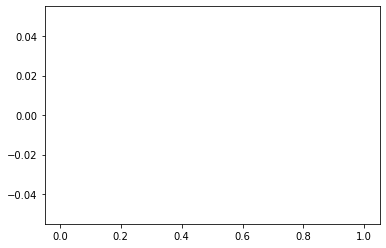

Tests Done in total: 0
Results Given in total: 0
Locations Moved in total: 908174
Tau Leap1 took 176.5940351486206


0.1 0.2 0.30000000000000004 0.4 0.5 0.6 0.7 0.7999999999999999 0.8999999999999999 0.9999999999999999 1.0999999999999999 1.2 1.3 1.4000000000000001 1.5000000000000002 1.6000000000000003 1.7000000000000004 1.8000000000000005 1.9000000000000006 2.0000000000000004 2.1000000000000005 2.2000000000000006 2.3000000000000007 2.400000000000001 2.500000000000001 2.600000000000001 2.700000000000001 2.800000000000001 2.9000000000000012 3.0000000000000013 3.1000000000000014 3.2000000000000015 3.3000000000000016 3.4000000000000017 3.5000000000000018 3.600000000000002 3.700000000000002 3.800000000000002 3.900000000000002 4.000000000000002 4.100000000000001 4.200000000000001 4.300000000000001 4.4 4.5 4.6 4.699999999999999 4.799999999999999 4.899999999999999 4.999999999999998 5.099999999999998 5.1999999999999975 5.299999999999997 5.399999999999997 5.4999999999999964 5.599999999999996 5.699999999999996 5.799999999999995 5.899999999999995 5.999999999999995 6.099999999999994 6.199999999999994 6.29999999999

45.60000000000038 45.70000000000038 45.80000000000038 45.90000000000038 46.000000000000384 46.100000000000385 46.20000000000039 46.30000000000039 46.40000000000039 46.50000000000039 46.60000000000039 46.700000000000394 46.800000000000395 46.9000000000004 47.0000000000004 47.1000000000004 47.2000000000004 47.3000000000004 47.400000000000404 47.500000000000405 47.600000000000406 47.70000000000041 47.80000000000041 47.90000000000041 48.00000000000041 48.10000000000041 48.200000000000415 48.300000000000416 48.40000000000042 48.50000000000042 48.60000000000042 48.70000000000042 48.80000000000042 48.900000000000425 49.000000000000426 49.10000000000043 49.20000000000043 49.30000000000043 49.40000000000043 49.50000000000043 49.600000000000435 49.700000000000436 49.80000000000044 49.90000000000044 50.00000000000044 50.10000000000044 50.20000000000044 50.300000000000445 50.400000000000446 50.50000000000045 50.60000000000045 50.70000000000045 50.80000000000045 50.90000000000045 51.000000000000455

91.29999999999909 91.39999999999908 91.49999999999908 91.59999999999907 91.69999999999906 91.79999999999906 91.89999999999905 91.99999999999905 92.09999999999904 92.19999999999904 92.29999999999903 92.39999999999903 92.49999999999902 92.59999999999901 92.69999999999901 92.799999999999 92.899999999999 92.99999999999899 93.09999999999899 93.19999999999898 93.29999999999897 93.39999999999897 93.49999999999896 93.59999999999896 93.69999999999895 93.79999999999895 93.89999999999894 93.99999999999893 94.09999999999893 94.19999999999892 94.29999999999892 94.39999999999891 94.4999999999989 94.5999999999989 94.6999999999989 94.79999999999889 94.89999999999888 94.99999999999888 95.09999999999887 95.19999999999887 95.29999999999886 95.39999999999885 95.49999999999885 95.59999999999884 95.69999999999884 95.79999999999883 95.89999999999883 95.99999999999882 96.09999999999881 96.19999999999881 96.2999999999988 96.3999999999988 96.49999999999879 96.59999999999879 96.69999999999878 96.79999999999878 9

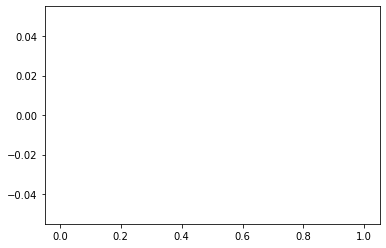

Tests Done in total: 911678
Results Given in total: 910775
Locations Moved in total: 204593
Tau Leap2 took 175.58733749389648


In [126]:
Tpars1 = [0,0.99,1,5]
Tpars2 = [1,0.99,1,5]
Tpars3 = [1,0.99,1,5]

tf=100

s = time.time()
tl_plot1 = Tau_Leap(rate_array, Cpars, Tpars1, old_n, old_pop, old_n_per_location, tf,False)
e = time.time()
print("Tau Leap1 took "+str(e-s))

s = time.time()
tl_plot2 = Tau_Leap(rate_array, Cpars, Tpars2, old_n, old_pop, old_n_per_location, tf,False)
e = time.time()
print("Tau Leap2 took "+str(e-s))

# s = time.time()
# tl_plot3 = Tau_Leap(rate_array, Cpars, Tpars3, old_n, old_pop, old_n_per_location, tf,True)
# e = time.time()
# print("Tau Leap3 took "+str(e-s))


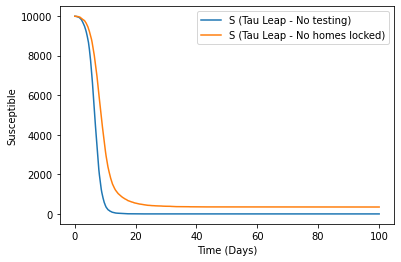

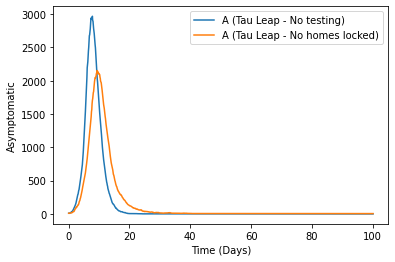

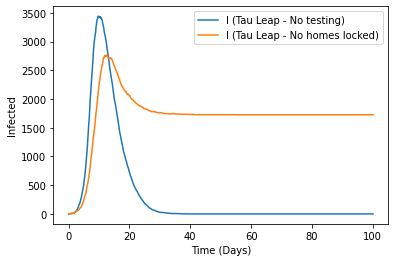

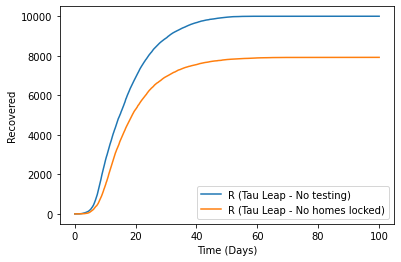

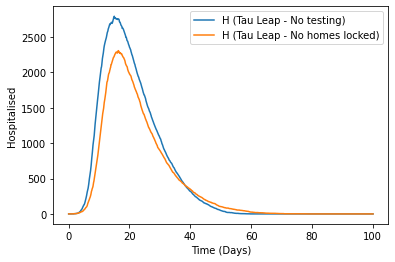

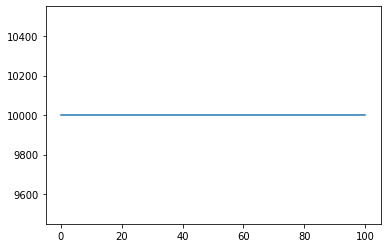

In [125]:
label_names = ["t","Susceptible","Asymptomatic","Infected","Recovered","Hospitalised"]
for i in range(1,6):
    plt.plot(tl_plot1[:,0],tl_plot1[:,i],label=label_names[i][0]+" (Tau Leap - No testing)")
    plt.plot(tl_plot2[:,0],tl_plot2[:,i],label=label_names[i][0]+" (Tau Leap - No homes locked)")
#     plt.plot(tl_plot3[:,0],tl_plot3[:,i],label=label_names[i][0]+" (Tau Leap - Homes locked)")
#     plt.plot(g_plots[:,0],g_plots[:,i],label=label_names[i][0]+" (Gillespie)")
    plt.xlabel("Time (Days)")
    plt.ylabel(label_names[i])
#     plt.xlim(-10,20)
    plt.legend()
    plt.show()
    
plt.plot(tl_plot1[:,0],tl_plot1[:,1]+tl_plot1[:,2]+tl_plot1[:,3]+tl_plot1[:,4]+tl_plot1[:,5])


<ipython-input-95-166609b3c62b>:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(tl_plot3[:,0],np.log(tl_plot3[:,3]),label=label_names[i][0]+" (Log Tau Leap - Homes locked)")


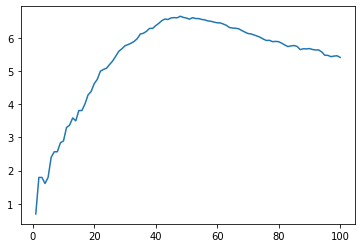

In [95]:
plt.plot(tl_plot3[:,0],np.log(tl_plot3[:,3]),label=label_names[i][0]+" (Log Tau Leap - Homes locked)")

In [ ]:
def Gillespie_Run(rate, Cpars, Tpars, n0, old_pop, old_n_per_loc, T):
    
    random_test_rate =Tpars[0]
    test_sensitivity =Tpars[1]
    test_specificity =Tpars[2]
    finish_test_rate =Tpars[3]
    
    pop = np.copy(old_pop)
    n_per_location = np.copy(old_n_per_loc)
    
    is_confined = np.zeros(n_pop,bool)
    is_dead     = np.zeros(n_pop,bool)
    being_tested= np.zeros(n_pop,bool)
    
    # [ S, A, I, R, H ]
    # [ 0, 1, 2, 3, 4 ]
        
    n = np.copy(n0)
    N = np.sum(n)
    
    output = np.append(0,n0)
    
    t=0.0
    t_out = 0
    
    while(t < T):
        
        if(t>=t_out):
            output = np.vstack((output, np.append(t_out,n)))
            t_out+=1
            #print(t_out)
                
        is_not_conf_or_dead = np.logical_not(is_confined+is_dead)   # Boolean array of people neither confined nor dead 
        
        a = np.zeros(len(n)+4)

        a[0] =        rate[0][1] * np.sum(n_per_location[:,0]* (Cpars[1]* n_per_location[:,1] + Cpars[2]*n_per_location[:,2] + Cpars[4]*n_per_location[:,4]))/1
        a[1] = a[0] + rate[1][2] * n[1]
        a[2] = a[1] + rate[1][3] * n[1]
        a[3] = a[2] + rate[2][3] * n[2]
        a[4] = a[3] + rate[2][4] * n[2]
        a[5] = a[4] + rate[4][3] * n[4]
        
        a[6]= a[5]+ np.sum(is_not_conf_or_dead)*random_test_rate
        a[7]= a[6]+ np.sum(being_tested)*finish_test_rate 
        a[8]= a[7]+ np.sum(is_not_conf_or_dead*link_weight)
        
        dt = -np.log(np.random.uniform(0.0,1.0)) / a[-1]
        t = t+dt

        p = np.random.uniform(0.0,1.0) * a[-1]

        if(p < a[0]):  # S -> A
            psum = 0
                                                                                                                      
            for i in range(0,n_pop):
                if(pop[i][0]==0):
                    psum += rate[0][1]* (Cpars[1]*n_per_location[pop[i][3] ][1] + Cpars[2] * n_per_location[pop[i][3] ][2] + Cpars[4]*n_per_location[pop[i][3]][4])/1
                    
                    if(psum>p):
                        break
                        
                                                                                                                      
            # Set the individual to asymptomatic
            pop[i][0] = 1
            
            n[0] = n[0] - 1 
            n[1] = n[1] + 1
            
            n_per_location[pop[i][3]][0] -= 1
            n_per_location[pop[i][3]][1] += 1
            
        elif(p < a[1]): # A -> I
            psum = a[0]
            
            for i in range(0,n_pop):
                if(pop[i][0]==1):
                    psum += rate[1][2]
                    
                    if(psum>p):
                        break

            
            # Set the individual to infected
            pop[i][0] = 2
            
            n[1] = n[1] - 1 
            n[2] = n[2] + 1
            
            n_per_location[pop[i][3]][1] -= 1
            n_per_location[pop[i][3]][2] += 1
            
            
        elif(p < a[2]): # A -> R
            psum = a[1]
            
            for i in range(0,n_pop):
                if(pop[i][0]==1):
                    psum += rate[1][3]
                    
                    if(psum>p):
                        break

            # Set the individual to recovered
            pop[i][0] = 3
            
            n[1] = n[1] - 1 
            n[3] = n[3] + 1
            
            n_per_location[pop[i][3]][1] -= 1
            n_per_location[pop[i][3]][3] += 1
            
        
        elif(p < a[3]): # I -> R
            psum = a[2]
            
            for i in range(0,n_pop):
                if(pop[i][0]==2):
                    psum += rate[2][3]
                    
                    if(psum>p):
                        break

            
            # Set the individual to recovered
            pop[i][0] = 3
            
            n[2] = n[2] - 1 
            n[3] = n[3] + 1
            
            n_per_location[pop[i][3]][2] -= 1
            n_per_location[pop[i][3]][3] += 1
            
            
            
        elif(p < a[4]): # I -> H
            psum = a[3]
            
            for i in range(0,n_pop):
                if(pop[i][0]==2):
                    psum += rate[2][4]
                    
                    if(psum>p):
                        break

            # Set the individual to hospitalised
            pop[i][0] = 4
            
            n[2] = n[2] - 1 
            n[4] = n[4] + 1
            
            n_per_location[pop[i][3]][2] -= 1
            n_per_location[pop[i][3]][4] += 1
            
            
        
        elif(p < a[5]):  # H -> R
            psum = a[4]
            
            for i in range(0,n_pop):
                if(pop[i][0]==4):
                    psum += rate[4][3]
                    
                    if(psum>p):
                        break

            # Set the individual to recovered
            pop[i][0] = 3
            
            n[4] = n[4] - 1 
            n[3] = n[3] + 1
            
            n_per_location[pop[i][3]][4] -= 1
            pop[i][3] = pop[i][1]               # Send them home
            n_per_location[pop[i][3]][3] += 1
            
            
            
        elif(p < a[6]):                                     # Conduct a random test
            psum = a[5]

            for i in range(0,n_pop):
                if(is_not_conf_or_dead[i]): # If the person isn't confined or dead
                    psum += random_test_rate
                   
                    if(psum>p):
                        break

            being_tested[i]=True

        elif(p < a[7]):
            psum = a[6]
            
            for i in range(0,n_pop):

                if being_tested[i] == True:
                    psum += finish_test_rate

                    if(psum>p):
                        break

            being_tested[i]=False    

            if ((pop[i][0]==1 or pop[i][0]==2 or pop[i][0]==4) and uniform(0.0,1.0)<test_sensitivity): # If the person is infected (or hospitalised) and the test works
                is_confined[i] = True                                # They are confined
                
                n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement infected in current (NET or HOME) location of person
                pop[i][3] = randint(n_hospitals)#pop[i][1]                      # Send them to a hospital at random (set current location to home location)
                n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment infected in HOME location of person
        
        
# <-------## TO DO : SET A PROTOCOL IN PLACE FOR TESTING HOSPITALISED PEOPLE ###############
        
        
        
        elif(p < a[8]):                                              # All else failing, move people around
            psum = a[7]
            
            for i in range(0,n_pop):

                if (not is_confined[i] and not is_dead[i]):  # If they aren't confined or dead
                    psum += link_weight[i]                 # move them to their other location

                    if(psum>p):
                        break

            home_loc = pop[i][1]
            net_loc  = pop[i][2]

            if(pop[i][3]==home_loc):                       # If the person is at home
                pop[i][3] = net_loc                        # move them to their network location
                
                for j in range(0,len(labels)):
                    if(pop[i][0]==j):
                        n_per_location[home_loc][j] -= 1
                        n_per_location[net_loc][j] += 1     
                
            elif(pop[i][3]==net_loc):
                pop[i][3] = home_loc                       # otherwise move them home
                
                for j in range(0,len(labels)):
                    if(pop[i][0]==j):
                        n_per_location[net_loc][j] -= 1
                        n_per_location[home_loc][j] += 1
            else:
                print("Current location neither home nor network!")
        
        else:
            print("(Gillespie) Something went wrong.")
    
    return output
    

(array([3., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

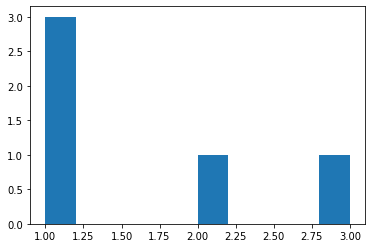

In [66]:
plt.hist([1,1,2,1,3])